<a href="https://colab.research.google.com/github/yuvalira/Adversarial-Attacks-Article/blob/main/models/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical Model — Decision Tree**
Decision Trees learn axis-aligned splits that partition the feature space into regions with mostly one class.
They are fast, interpretable (you can visualize the tree), but prone to overfitting unless regularized.

References:
- scikit-learn `DecisionTreeClassifier` (criterion, depth, etc.)

## Imports & setup

In [1]:
!pip -q install -U scikit-learn huggingface_hub

import os, re, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report, confusion_matrix)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.7 MB/s eta 0:00:00


## Load splits from HF

In [2]:
repo_id, repo_type = "yuvalira/adult_income_balanced", "dataset"  # TODO
def read_csv(repo_id, filename, repo_type="dataset"):
    p = hf_hub_download(repo_id=repo_id, filename=filename, repo_type=repo_type, token=False)
    return pd.read_csv(p)

train_data = read_csv(repo_id, "train.csv", repo_type)
val_data   = read_csv(repo_id, "val.csv",   repo_type)
print("Train:", train_data.shape, "| Val:", val_data.shape)

train.csv: 0.00B [00:00, ?B/s]

val.csv: 0.00B [00:00, ?B/s]

Train: (11687, 14) | Val: (2337, 14)


## Columns & config

In [3]:
auto_num = train_data.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns.tolist()
auto_cat = train_data.select_dtypes(include=['object','category','bool']).columns.tolist()

TARGET_COLUMN_NAME   = "income"               # TODO
TARGET_LABELS        = ["<=50K", ">50K"]      # TODO (order = ids)
SAMPLE_WEIGHT_COLUMN = None

NUMERIC_FEATURE_NAMES     = [c for c in auto_num if c != TARGET_COLUMN_NAME]
CATEGORICAL_FEATURE_NAMES = [c for c in auto_cat if c != TARGET_COLUMN_NAME]

## Prepare DFs (map target, cast categoricals to str)

In [4]:
label2id = {lbl:i for i,lbl in enumerate(TARGET_LABELS)}
id2label = {i:lbl for lbl,i in label2id.items()}

def prep(df):
    df = df.copy()
    df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(label2id)
    if df[TARGET_COLUMN_NAME].isna().any():
        raise ValueError("Unmapped targets—check TARGET_LABELS.")
    for c in CATEGORICAL_FEATURE_NAMES:
        if c in df.columns: df[c] = df[c].astype(str)
    return df

train_data, val_data = prep(train_data), prep(val_data)
n_classes = train_data[TARGET_COLUMN_NAME].nunique()
avg_mode = None if n_classes==2 else "macro"

## Pipeline: impute + ordinal-encode cats

In [5]:
numeric = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
pre = ColumnTransformer([
    ("num", numeric, NUMERIC_FEATURE_NAMES),
    ("cat", categorical, CATEGORICAL_FEATURE_NAMES),
])

dt = DecisionTreeClassifier(
    criterion="gini",      # or "entropy", "log_loss"
    max_depth=None,        # try e.g. 6-12 to curb overfitting
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

clf_dt = Pipeline([("preprocessor", pre), ("clf", dt)])

## Train & Evaluate

In [10]:
# If you still have `grid` in scope, use its best params; otherwise fall back to the values you printed.
try:
    BEST_PARAMS = grid.best_params_
except NameError:
    BEST_PARAMS = {
        "clf__class_weight": None,
        "clf__criterion": "gini",
        "clf__max_depth": 8,
        "clf__min_samples_leaf": 1,
    }

clf_dt.set_params(**BEST_PARAMS)
print("Using params:", BEST_PARAMS)

def split_xy(df):
    X = df.drop(columns=[TARGET_COLUMN_NAME]); y = df[TARGET_COLUMN_NAME].values
    sw = df[SAMPLE_WEIGHT_COLUMN].values if SAMPLE_WEIGHT_COLUMN else None
    return X, y, sw

Xtr, ytr, sw_tr = split_xy(train_data)
Xva, yva, sw_va = split_xy(val_data)

t0 = time.time()
clf_dt.fit(Xtr, ytr, **({"clf__sample_weight": sw_tr} if sw_tr is not None else {}))
print(f"Training time: {time.time()-t0:.2f}s")

# Predictions (default 0.5 threshold)
yp = clf_dt.predict(Xva)

# Probabilities (for ROC/AUC and threshold tuning)
pre = clf_dt.named_steps["preprocessor"]
clf = clf_dt.named_steps["clf"]
yp_prob = clf.predict_proba(pre.transform(Xva)) if hasattr(clf, "predict_proba") else None

# AUC (binary only)
if yp_prob is not None and yp_prob.ndim > 1 and yp_prob.shape[1] == 2:
    auc = roc_auc_score(yva, yp_prob[:, 1])
    print("Val AUC (0.5 thr):", round(auc, 4))

# Choose averaging mode for metrics
avg = "binary" if n_classes == 2 else "macro"

print(
    "Val metrics @0.5:",
    dict(
        accuracy=round(accuracy_score(yva, yp), 4),
        precision=round(precision_score(yva, yp, average=avg, zero_division=0), 4),
        recall=round(recall_score(yva, yp, average=avg, zero_division=0), 4),
        f1=round(f1_score(yva, yp, average=avg, zero_division=0), 4),
    ),
)

print(
    "\nReport @0.5:\n",
    classification_report(
        yva, yp, target_names=[id2label[i] for i in range(n_classes)], zero_division=0
    ),
)
print("Confusion @0.5:\n", confusion_matrix(yva, yp))

# --- OPTIONAL: simple threshold sweep to maximize accuracy on validation (binary only) ---
if yp_prob is not None and yp_prob.shape[1] == 2:
    scores = yp_prob[:, 1]
    # search a narrow band around 0.5; widen if you want
    thrs = np.linspace(0.3, 0.7, 81)
    accs = []
    for thr in thrs:
        yp_thr = (scores >= thr).astype(int)
        accs.append((thr, accuracy_score(yva, yp_thr)))
    best_thr, best_acc = max(accs, key=lambda x: x[1])

    yp_best = (scores >= best_thr).astype(int)
    print(f"\nBest threshold on val: {best_thr:.3f} | Accuracy: {best_acc:.4f}")
    print(
        "Val metrics @best-thr:",
        dict(
            accuracy=round(best_acc, 4),
            precision=round(precision_score(yva, yp_best, average="binary", zero_division=0), 4),
            recall=round(recall_score(yva, yp_best, average="binary", zero_division=0), 4),
            f1=round(f1_score(yva, yp_best, average="binary", zero_division=0), 4),
        ),
    )

Using params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_leaf': 1}
Training time: 0.06s
Val AUC (0.5 thr): 0.8981
Val metrics @0.5: {'accuracy': 0.8263, 'precision': 0.8068, 'recall': 0.8579, 'f1': 0.8315}

Report @0.5:
               precision    recall  f1-score   support

       <=50K       0.85      0.79      0.82      1169
        >50K       0.81      0.86      0.83      1168

    accuracy                           0.83      2337
   macro avg       0.83      0.83      0.83      2337
weighted avg       0.83      0.83      0.83      2337

Confusion @0.5:
 [[ 929  240]
 [ 166 1002]]

Best threshold on val: 0.480 | Accuracy: 0.8276
Val metrics @best-thr: {'accuracy': 0.8276, 'precision': 0.8053, 'recall': 0.8639, 'f1': 0.8335}


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [5, 8, 12, None],
    "clf__min_samples_leaf": [1, 5, 10, 20],
    "clf__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    estimator=clf_dt,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2
)

Xtr, ytr, _ = split_xy(train_data)
grid.fit(Xtr, ytr)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_leaf': 1}
Best CV accuracy: 0.8197138091321483


## ROC

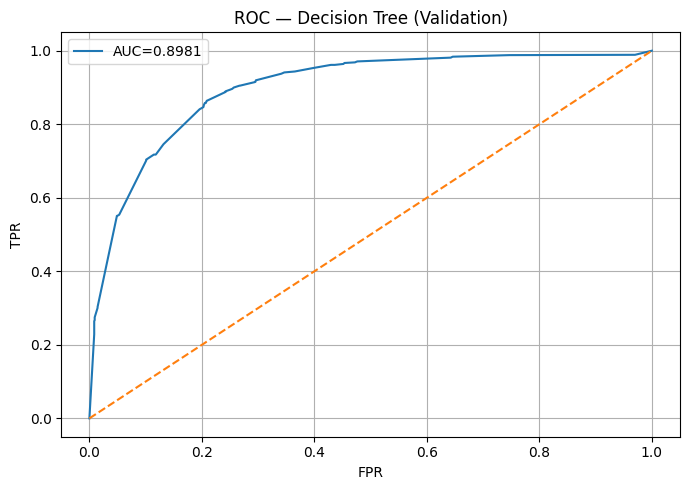

In [11]:
if yp_prob is not None and yp_prob.ndim>1 and yp_prob.shape[1]==2:
    fpr,tpr,_=roc_curve(yva, yp_prob[:,1]); auc=roc_auc_score(yva, yp_prob[:,1])
    plt.figure(figsize=(7,5)); plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC — Decision Tree (Validation)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

## Save Model

In [ ]:
#%% Save model
import joblib
safe_repo_id = re.sub(r'[^A-Za-z0-9_.-]+', '_', repo_id)
path = f"models/Decision_Tree_{safe_repo_id}.joblib"
os.makedirs("models", exist_ok=True); joblib.dump(clf_dt, path)
print("Saved:", os.path.abspath(path))